In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [3]:
# set random seed
np.random.seed(123)
tf.set_random_seed(123)

# import the training data 
X_total = pd.read_csv('X_musical_features.csv').drop('track_id', axis=1)

# import single genres y values
y_single_total = pd.read_csv('y_genres_onehot_single.csv').drop('Unnamed: 0', axis=1)

# import non-one-hotted y values
y_cold_single_total = pd.read_csv('y_genres_single.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_single_total, test_size=0.3, shuffle=False, stratify = None
)

# also split y cold 70/30
y_cold_train = y_cold_single_total.head(44559)
y_cold_test = y_cold_single_total.tail(y_cold_single_total.shape[0] - 44559)

# then do this for 
# *_train together
# *_test together
def unison_shuffled_copies(a, b, c):
    assert len(a) == b.shape[0]
    assert a.shape[0] == c.shape[0]
    
    p = np.random.permutation(len(a))
    return a.iloc[p, :], b.iloc[p, :], c.iloc[p, :]

#new variables with shuffled 
X_train_shuf, y_train_shuf, y_cold_train_shuf = unison_shuffled_copies(X_train, y_train, y_cold_train)

#also do this for test set

Testing for correctness in shuffling

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_shuf)
X_test_scaled = scaler.transform(X_test)

In [6]:
# del X_train, X_test

In [7]:
def create_model(neuron_1, neuron_2):
    model = keras.models.Sequential()
    sgd_optimizer = keras.optimizers.SGD(lr=0.1, decay=1e-7, momentum=0.9)

    # INPUT LAYER
    model.add(
        keras.layers.Dense(
            units=518,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='glorot_uniform',
            bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
            activation='relu',
        )
    )

    # HIDDEN LAYER 1
#     model.add(
#         keras.layers.Dense(
#             units=474,
#             input_dim=518,
#             kernel_initializer='glorot_uniform',
#             bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
#             activation='relu'
#         )
#     )

    # HIDDEN LAYER 2
    model.add(
        keras.layers.Dense(
            units=neuron_1,
            input_dim=518,
            kernel_initializer='glorot_uniform',
            bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
            activation='relu'
        )
    )

    # HIDDEN LAYER 3
    model.add(
        keras.layers.Dense(
            units=neuron_2,
            input_dim=neuron_1,
            kernel_initializer='glorot_uniform',
            bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
            activation='relu'
        )
    )

    # OUTPUT LAYER
    model.add(
        keras.layers.Dense(
            units=y_train.shape[1],
            input_dim=neuron_2,
            kernel_initializer='glorot_uniform',
            bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
            activation='softmax'
        )
    )

    model.compile(
        optimizer=sgd_optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    return model

## Best Things So Far
* Batch Size: **60** _(maybe 64 to optimize because of powers of 2)_
* Optimizer: **SGD**
* Learning Rate: **0.1**
* Momentum: **0.9**
* Neurons in Hidden Layer 1: **400**
* Neurons in Hidden Layer 2: **350**


In [8]:
model = KerasClassifier(
    build_fn=create_model,
    batch_size=64,
    epochs=20,
    verbose=0)

neuron_1 = [100, 150, 200, 250, 300, 350, 400]
neuron_2 = [100, 150, 200, 250, 300, 350, 400]
param_grid = dict(neuron_1=neuron_1, neuron_2=neuron_2)

grid = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    n_jobs=1,
    verbose=3,
)

#TRY RUNNING THIS WITH X_TRAIN_SCALED AND Y_TRAIN_SHUF, WE MAY BE USING THE UNSHUFFLED TEST DATA FOR THIS
#WHICH IS ONLY 30% OF THE TOTAL DATA AND IT IS UNSHUFFLED
grid_result = grid.fit(X_test_scaled, y_test)

C:\Users\TonyX\Desktop\WPy-3670\python-3.6.7.amd64\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV] neuron_1=100, neuron_2=100 ......................................
[CV]  neuron_1=100, neuron_2=100, score=0.17404963872434956, total=  20.5s
[CV] neuron_1=100, neuron_2=100 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s


[CV]  neuron_1=100, neuron_2=100, score=0.25164938737040526, total=  22.5s
[CV] neuron_1=100, neuron_2=100 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   43.9s remaining:    0.0s


[CV]  neuron_1=100, neuron_2=100, score=0.2744697564760719, total=  20.6s
[CV] neuron_1=100, neuron_2=150 ......................................
[CV]  neuron_1=100, neuron_2=150, score=0.18096135726635687, total=  21.0s
[CV] neuron_1=100, neuron_2=150 ......................................
[CV]  neuron_1=100, neuron_2=150, score=0.22730128809299402, total=  21.5s
[CV] neuron_1=100, neuron_2=150 ......................................
[CV]  neuron_1=100, neuron_2=150, score=0.3558523173757828, total=  21.0s
[CV] neuron_1=100, neuron_2=200 ......................................
[CV]  neuron_1=100, neuron_2=200, score=0.19761231545378793, total=  21.3s
[CV] neuron_1=100, neuron_2=200 ......................................
[CV]  neuron_1=100, neuron_2=200, score=0.16666666666666666, total=  22.2s
[CV] neuron_1=100, neuron_2=200 ......................................
[CV]  neuron_1=100, neuron_2=200, score=0.33967007072957034, total=  21.8s
[CV] neuron_1=100, neuron_2=250 ...................

[CV]  neuron_1=200, neuron_2=350, score=0.34029850747673324, total=  39.0s
[CV] neuron_1=200, neuron_2=400 ......................................
[CV]  neuron_1=200, neuron_2=400, score=0.16839459640516113, total=  35.9s
[CV] neuron_1=200, neuron_2=400 ......................................
[CV]  neuron_1=200, neuron_2=400, score=0.25651900722588755, total=  36.1s
[CV] neuron_1=200, neuron_2=400 ......................................
[CV]  neuron_1=200, neuron_2=400, score=0.3274155538379912, total=  36.1s
[CV] neuron_1=250, neuron_2=100 ......................................
[CV]  neuron_1=250, neuron_2=100, score=0.17829092053864462, total=  33.3s
[CV] neuron_1=250, neuron_2=100 ......................................
[CV]  neuron_1=250, neuron_2=100, score=0.2345271756204838, total=  33.7s
[CV] neuron_1=250, neuron_2=100 ......................................
[CV]  neuron_1=250, neuron_2=100, score=0.3498821681372687, total=  33.9s
[CV] neuron_1=250, neuron_2=150 ....................

[CV]  neuron_1=350, neuron_2=250, score=0.3244304792134666, total=  55.5s
[CV] neuron_1=350, neuron_2=300 ......................................
[CV]  neuron_1=350, neuron_2=300, score=0.18567389256355712, total=  57.7s
[CV] neuron_1=350, neuron_2=300 ......................................
[CV]  neuron_1=350, neuron_2=300, score=0.23421300659754948, total=  57.7s
[CV] neuron_1=350, neuron_2=300 ......................................
[CV]  neuron_1=350, neuron_2=300, score=0.3377847604061428, total=  57.6s
[CV] neuron_1=350, neuron_2=350 ......................................
[CV]  neuron_1=350, neuron_2=350, score=0.18331762490091255, total=  58.9s
[CV] neuron_1=350, neuron_2=350 ......................................
[CV]  neuron_1=350, neuron_2=350, score=0.23217090794847628, total=  58.0s
[CV] neuron_1=350, neuron_2=350 ......................................
[CV]  neuron_1=350, neuron_2=350, score=0.33857030639101554, total= 1.0min
[CV] neuron_1=350, neuron_2=400 ...................

[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed: 103.7min finished


In [9]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.264649 using {'neuron_1': 400, 'neuron_2': 350}
0.233387 (0.042982) with: {'neuron_1': 100, 'neuron_2': 100}
0.254700 (0.073980) with: {'neuron_1': 100, 'neuron_2': 150}
0.234644 (0.075326) with: {'neuron_1': 100, 'neuron_2': 200}
0.241294 (0.086843) with: {'neuron_1': 100, 'neuron_2': 250}
0.192805 (0.045957) with: {'neuron_1': 100, 'neuron_2': 300}
0.257056 (0.056714) with: {'neuron_1': 100, 'neuron_2': 350}
0.208567 (0.029982) with: {'neuron_1': 100, 'neuron_2': 400}
0.263549 (0.061066) with: {'neuron_1': 150, 'neuron_2': 100}
0.255904 (0.059757) with: {'neuron_1': 150, 'neuron_2': 150}
0.249044 (0.083167) with: {'neuron_1': 150, 'neuron_2': 200}
0.255380 (0.072007) with: {'neuron_1': 150, 'neuron_2': 250}
0.252239 (0.085575) with: {'neuron_1': 150, 'neuron_2': 300}
0.251558 (0.064145) with: {'neuron_1': 150, 'neuron_2': 350}
0.245431 (0.064980) with: {'neuron_1': 150, 'neuron_2': 400}
0.240561 (0.042988) with: {'neuron_1': 200, 'neuron_2': 100}
0.182856 (0.034922) with: {'n

In [ ]:
# history = model.fit(
# X_train_scaled, y_train_shuf,
# batch_size=100, epochs=7,
# verbose=1,
# validation_data=(X_test_scaled, y_test),
# )

# plt.plot(history.history['val_acc'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['gn', 'gu', 'ln', 'lu', 'hn', 'hu'], loc='upper left')
# plt.show()

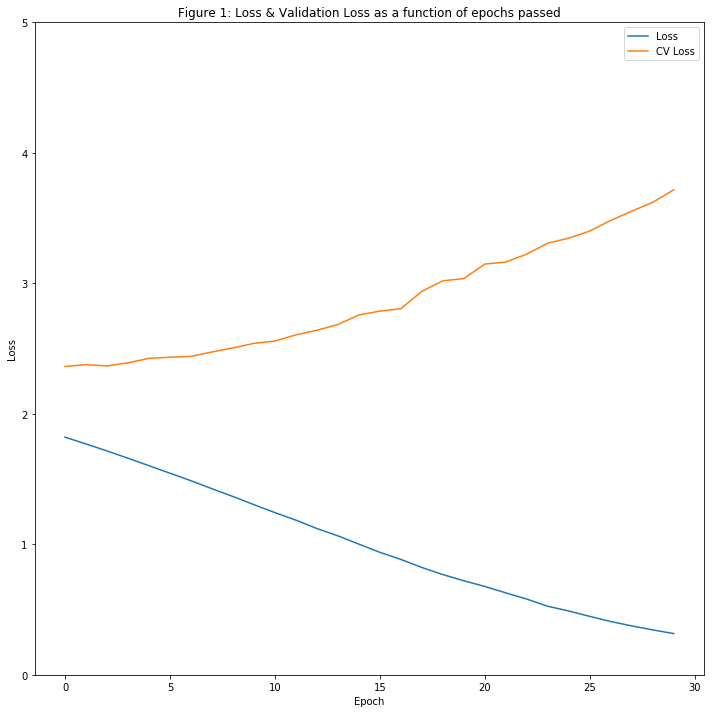

In [55]:
# loss, val_loss = history.history.values()

# plt.plot(loss, label="Loss")
# plt.plot(val_loss, label="CV Loss")
# plt.legend()
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.ylim(bottom=0, top=5)
# plt.title('Figure 1: Loss & Validation Loss as a function of epochs passed')
# plt.rcParams["figure.figsize"] = [12,12]
# plt.show()

In [56]:
# y_train_pred = model.predict_classes(X_train_scaled, verbose=0)
# y_test_pred = model.predict_classes(X_test_scaled, verbose=0)

# train_acc = np.sum(y_cold_train_shuf.values.flatten() == y_train_pred, axis=0) / 44559
# test_acc = np.sum(y_cold_test.values.flatten() == y_test_pred, axis=0) / 19097

# print(f"Accuracy on training set: {train_acc}")
# print(f"Accuracy on test set: {test_acc}")

Accuracy on training set: 0.8906842613164568
Accuracy on test set: 0.21170864533696393
